In [1]:
import geogridfusion
import pvdeg

import os
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xarray as xr
import geogridfusion.templates

# utility functions for testing data in this tutorial 
def subset(xlower, xupper, ylower, yupper) -> gpd.GeoSeries:
    """generate and subset points in colorado"""
    xmin, ymin, xmax, ymax = -109.059196,36.992751,-102.042126,41.00198
    steps = 10

    lons = np.linspace(xmin, xmax, steps)[xlower:xupper]
    lats = np.linspace(ymin, ymax, steps)[ylower:yupper]

    x, y = np.meshgrid(lons, lats)
    grid_points = gpd.points_from_xy(x.ravel(), y.ravel(), crs="EPSG:4326")

    return grid_points

def co_plot(geoseries: gpd.GeoSeries) -> None:
    """quick plot colorado"""
    lambert_proj = ccrs.LambertConformal(central_longitude=-105, central_latitude=39.5)
    fig, ax = plt.subplots(figsize=(4, 3), subplot_kw={"projection": lambert_proj})
    ax.set_extent([-120, -90, 30, 50], crs=ccrs.PlateCarree())  # Broader bounds for zoomed-out view
    ax.coastlines()  # Add coastlines for reference
    for point in geoseries:
        ax.plot(point.x, point.y, 'ro', transform=ccrs.PlateCarree())  # Transform to Lambert

    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black')
    plt.show()

def check_intersection_point_array(a, b) -> bool:
    # Convert to GeoSeries
    left_gs = gpd.GeoSeries(a)
    right_gs = gpd.GeoSeries(b)

    # Check for intersections
    any_intersection = left_gs.apply(
        lambda geom: right_gs.intersects(geom).any()
    ).any()

    return any_intersection

def download_points(geometryarray) -> tuple[xr.Dataset, pd.DataFrame, np.ndarray]:
    """geometry array containing Shapely.Point"""
    tuple_coords = [tuple(coord) for coord in np.column_stack((geometryarray.y, geometryarray.x))]

    weather, meta, failed = pvdeg.weather.weather_distributed(
        database="PVGIS",
        coords=tuple_coords,
    )

    return weather, meta, failed

def save_weather_tuples_to_disk(tuples, folder, prefixes):
    """
    Save xarray.Dataset and pandas.DataFrame tuples to disk.

    Parameters:
    - tuples: List of tuples, where each tuple contains an xarray.Dataset and a pandas.DataFrame.
    - folder: Directory where the files will be saved.
    - prefixes: List of file prefixes to distinguish between different datasets.
    """
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Save each tuple
    for (dataset, dataframe, _failed), prefix in zip(tuples, prefixes):
        # Save the xarray.Dataset as a NetCDF file
        dataset_path = os.path.join(folder, f"{prefix}_dataset.nc")
        dataset.to_netcdf(dataset_path, engine="h5netcdf")
        print(f"Saved dataset to {dataset_path}")

        # Save the pandas.DataFrame as a CSV file
        dataframe_path = os.path.join(folder, f"{prefix}_dataframe.csv")
        dataframe.to_csv(dataframe_path, index=False)
        print(f"Saved dataframe to {dataframe_path}")

def load_weather_data_from_disk(folder, prefixes):
    """
    Load xarray.Dataset and pandas.DataFrame from disk into a dictionary.

    Parameters:
    - folder: Directory where the files are stored.
    - prefixes: List of file prefixes used to identify the datasets.

    Returns:
    - A dictionary where each key is the prefix and the value is a tuple (xarray.Dataset, pandas.DataFrame).
    """
    weather_data = {}
    
    for prefix in prefixes:
        # Construct file paths
        dataset_path = os.path.join(folder, f"{prefix}_dataset.nc")
        dataframe_path = os.path.join(folder, f"{prefix}_dataframe.csv")
        
        # Load the xarray.Dataset
        dataset = xr.load_dataset(dataset_path, engine="h5netcdf")
        
        # Load the pandas.DataFrame
        dataframe = pd.read_csv(dataframe_path)
        
        # Store in dictionary
        weather_data[prefix] = (dataset, dataframe)
    
    return weather_data

In [ ]:
co = subset(0, -1, 0, -1)
co_plot(co)

In [ ]:
bottom_left_quad = subset(0, 5, 0, 5)
co_plot(bottom_left_quad)

In [ ]:
bottom_right_quad = subset(5, -1, 0, 5)
co_plot(bottom_right_quad)

In [ ]:
overlapping = subset(0, -1, 2, 3)
co_plot(overlapping)

In [ ]:
# we can see that we have generated an overlapping array
print(check_intersection_point_array(bottom_right_quad, overlapping))
print(check_intersection_point_array(bottom_left_quad, overlapping))

lets download the points for each of these regions

In [ ]:
client = pvdeg.geospatial.start_dask()

# we will collect weather data for these points
# we need to pass a list of tuples not a numpy array

bottom_left_weather_tuple = download_points(bottom_left_quad)
bottom_right_weather_tuple = download_points(bottom_right_quad)
overlapping_weather_tuple = download_points(overlapping)

In [ ]:
# Save tuples to disk
save_weather_tuples_to_disk(
    tuples=[
        bottom_left_weather_tuple,
        bottom_right_weather_tuple,
        overlapping_weather_tuple
    ],
    folder="weather_data",
    prefixes=["bottom_left", "bottom_right", "overlapping"]
)

now that we have saved the data we can load it using the prefixes defined above.

In [2]:
# Example usage
weather_data_dict = load_weather_data_from_disk(
    folder="weather_data",
    prefixes=["bottom_left", "bottom_right", "overlapping"]
)

bl_weather, bl_meta = weather_data_dict["bottom_left"]
br_weather, br_meta = weather_data_dict["bottom_right"]
ov_weather, ov_meta = weather_data_dict["overlapping"]

bl = pvdeg.store._combine_geo_weather_meta(bl_weather, bl_meta)
br = pvdeg.store._combine_geo_weather_meta(br_weather, br_meta)
ov = pvdeg.store._combine_geo_weather_meta(ov_weather, ov_meta)

Goals

- check if input matches expected existing dataset.
- check if points are overlapping, new data vs exising dataset
    - resolve overlap: ignore or overwrite

In [3]:
xr.open_zarr(geogridfusion.pvgis_tmy.path)

<xarray.Dataset> Size: 70kB
Dimensions:                 (gid: 0, time: 8760)
Coordinates:
  * gid                     (gid) int32 0B 
  * time                    (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12...
Data variables: (12/15)
    IR(h)                   (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    Source                  (gid) <U5 0B dask.array<chunksize=(0,), meta=np.ndarray>
    altitude                (gid) float64 0B dask.array<chunksize=(0,), meta=np.ndarray>
    dhi                     (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    dni                     (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    ghi                     (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    ...                      ...
    pressure                (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    relative_humidity       (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    temp_air                (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    wind_direction          (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>
    wind_height             (gid) int64 0B dask.array<chunksize=(0,), meta=np.ndarray>
    wind_speed              (gid, time) float64 0B dask.array<chunksize=(0, 8760), meta=np.ndarray>

In [5]:
geogridfusion.store(dataset=bl, store=geogridfusion.pvgis_tmy)

loaded = geogridfusion.get(source=geogridfusion.pvgis_tmy)

loaded

<xarray.Dataset> Size: 16MB
Dimensions:                 (gid: 25, time: 8760)
Coordinates:
  * gid                     (gid) int32 100B 5910997 5911015 ... 6078730 6078747
  * time                    (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12...
Data variables: (12/15)
    IR(h)                   (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    Source                  (gid) <U5 500B dask.array<chunksize=(1,), meta=np.ndarray>
    altitude                (gid) float64 200B dask.array<chunksize=(1,), meta=np.ndarray>
    dhi                     (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    dni                     (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    ghi                     (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    ...                      ...
    pressure                (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    relative_humidity       (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    temp_air                (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    wind_direction          (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    wind_height             (gid) int64 200B dask.array<chunksize=(1,), meta=np.ndarray>
    wind_speed              (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>

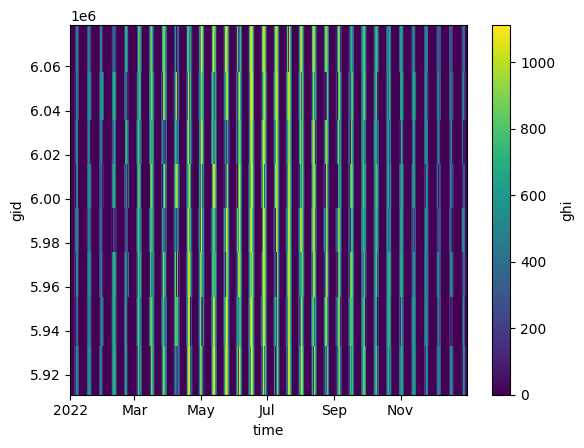

In [6]:
loaded.ghi.plot()

In [8]:
geogridfusion.store(dataset=ov, store=geogridfusion.pvgis_tmy)

loaded = geogridfusion.get(source=geogridfusion.pvgis_tmy)

loaded

<xarray.Dataset> Size: 18MB
Dimensions:                 (gid: 29, time: 8760)
Coordinates:
  * gid                     (gid) int32 116B 5910997 5911015 ... 6078730 6078747
  * time                    (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12...
Data variables: (12/15)
    IR(h)                   (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    Source                  (gid) <U5 580B dask.array<chunksize=(1,), meta=np.ndarray>
    altitude                (gid) float64 232B dask.array<chunksize=(1,), meta=np.ndarray>
    dhi                     (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    dni                     (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    ghi                     (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    ...                      ...
    pressure                (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    relative_humidity       (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    temp_air                (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    wind_direction          (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    wind_height             (gid) int64 232B dask.array<chunksize=(1,), meta=np.ndarray>
    wind_speed              (gid, time) float64 2MB dask.array<chunksize=(1, 8760), meta=np.ndarray>

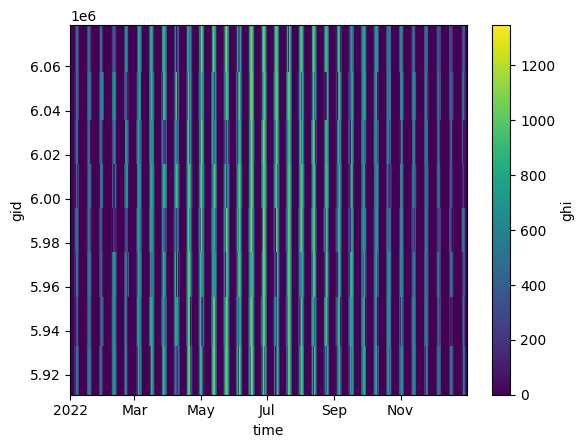

In [10]:
loaded.ghi.plot()

In [11]:
geogridfusion.store(dataset=br, store=geogridfusion.pvgis_tmy)

loaded = geogridfusion.get(source=geogridfusion.pvgis_tmy)

loaded

<xarray.Dataset> Size: 28MB
Dimensions:                 (gid: 45, time: 8760)
Coordinates:
  * gid                     (gid) int32 180B 5910997 5911015 ... 6078798 6078815
  * time                    (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12...
Data variables: (12/15)
    IR(h)                   (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    Source                  (gid) <U5 900B dask.array<chunksize=(1,), meta=np.ndarray>
    altitude                (gid) float64 360B dask.array<chunksize=(1,), meta=np.ndarray>
    dhi                     (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    dni                     (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    ghi                     (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    ...                      ...
    pressure                (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    relative_humidity       (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    temp_air                (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    wind_direction          (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>
    wind_height             (gid) int64 360B dask.array<chunksize=(1,), meta=np.ndarray>
    wind_speed              (gid, time) float64 3MB dask.array<chunksize=(1, 8760), meta=np.ndarray>

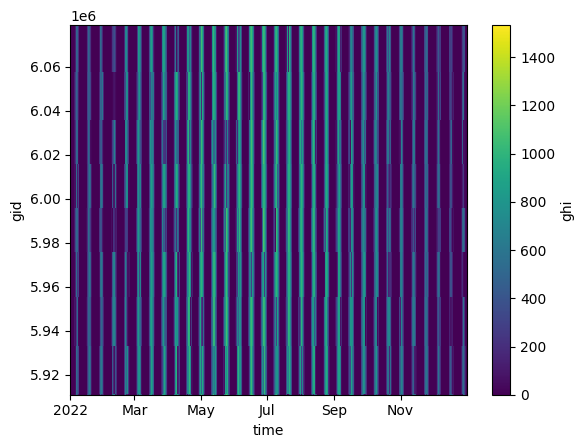

In [13]:
loaded.ghi.plot()

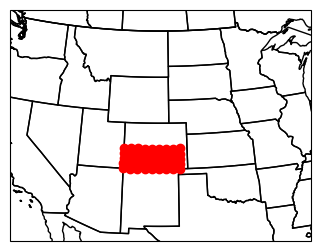

In [17]:
co_plot(
    gpd.points_from_xy(x=loaded.longitude.values, y=loaded.latitude.values)
)
